In [1]:
import pandas as pd 
from sklearn.model_selection import train_test_split
import nltk
import string 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer 
nltk.download('punkt')
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from matplotlib import pyplot as plt 
from sklearn.metrics import plot_precision_recall_curve 
import numpy as np 
from sklearn.model_selection import GridSearchCV




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Onyaxoxo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv("./labeled.csv", sep=",")


In [3]:
df.shape


(14412, 2)

In [4]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
df["toxic"] = df["toxic"].apply(int)

In [6]:
df.head(5)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [7]:
df["toxic"].value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [8]:
for _ in df[df["toxic"] == 1]["comment"].head(5):
    print(_)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)



In [9]:
for _ in df[df["toxic"] == 0]["comment"].head(5):
    print(_)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [10]:
train_df, test_df = train_test_split(df, test_size=500)

In [11]:
test_df.shape

(500, 2)

In [12]:
test_df["toxic"].value_counts()

0    324
1    176
Name: toxic, dtype: int64

In [13]:
train_df["toxic"].value_counts()

0    9262
1    4650
Name: toxic, dtype: int64

Модель логистической регрессии
1. разбивка комментария по пробелам и знакам пунктуации
2. удаляется пунктуация 
3. удаление стоп-слова
4. стемминг. (все слова с нижнем регистром и без окончаний)

In [18]:
sentence_example = df.iloc[1]["comment"]
tokens = word_tokenize(sentence_example, language="russian")
tokens_without_punctuation =[i for i in tokens if i not in string.punctuation]
russian_stop_words = stopwords.words("russian")
tokens_without_stop_words_and_punctuation = [i for i in tokens_without_punctuation if i not in russian_stop_words]
snowball = SnowballStemmer(language="russian")
stemmed_tokens = [snowball.stem(i) for i in tokens_without_stop_words_and_punctuation]

In [19]:
print(f"Исходный текст: {sentence_example}")
print("-------------------------------------")
print(f"Токеныт: {tokens}")
print("-------------------------------------")
print(f"Токены без пунктуации: {tokens_without_punctuation}")
print("-------------------------------------")
print(f"Токены без пунктуации и стоп слов: {tokens_without_stop_words_and_punctuation}")
print("-------------------------------------")
print(f"Токены после стемминга: {stemmed_tokens}")
print("-------------------------------------")

Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

-------------------------------------
Токеныт: ['Хохлы', ',', 'это', 'отдушина', 'затюканого', 'россиянина', ',', 'мол', ',', 'вон', ',', 'а', 'у', 'хохлов', 'еще', 'хуже', '.', 'Если', 'бы', 'хохлов', 'не', 'было', ',', 'кисель', 'их', 'бы', 'придумал', '.']
-------------------------------------
Токены без пунктуации: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'а', 'у', 'хохлов', 'еще', 'хуже', 'Если', 'бы', 'хохлов', 'не', 'было', 'кисель', 'их', 'бы', 'придумал']
-------------------------------------
Токены без пунктуации и стоп слов: ['Хохлы', 'это', 'отдушина', 'затюканого', 'россиянина', 'мол', 'вон', 'хохлов', 'хуже', 'Если', 'хохлов', 'кисель', 'придумал']
-------------------------------------
ТОкены после стемминга: ['хохл', 'эт', 'отдушин', 'затюкан', 'россиянин', 'мол', 'вон', 'хохл', 'хуж', 'есл', 'хохл', 'кисе

In [20]:
snowball = SnowballStemmer(language="russian")
russian_stop_words = stopwords.words("russian")

def tokenize_sentence(sentence: str, remove_stop_words: bool = True):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    if remove_stop_words:
        tokens = [i for i in tokens if i not in russian_stop_words]
    tokens = [snowball.stem(i) for i in tokens]
    return tokens

tokenize_sentence(sentence_example)

Tfidf векторизация.

In [22]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))

In [24]:
features = vectorizer.fit_transform(train_df["comment"])

Обучение модели логистической регрессии.
random_state=0 - воспроизводимые результаты 
метод fit используется для обучения

In [25]:
model =LogisticRegression(random_state=0)
model.fit(features, train_df["toxic"])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
LogisticRegression(random_state=0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
model.predict(features[0])

array([0], dtype=int64)

In [30]:
train_df["comment"].iloc[0]

'У моего дяди было тоже самое, лечили гастрит, умер от рака. У нас диагностов нет.\n'

In [31]:
model_pipeline = Pipeline ([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0))
])

In [32]:
model_pipeline.fit(train_df["comment"], train_df["toxic"])

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...\\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x0000023871B03A68>,
                                 use_idf=True, vocabulary=None)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fi

In [33]:
model_pipeline.predict(["эх, как же хорошо на улице"])

array([0], dtype=int64)

In [39]:
model_pipeline.predict(["нахрен оно тебе надо?"])

array([1], dtype=int64)

Метрики модели. 

In [41]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.912

In [42]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"]))

0.6477272727272727

In [50]:
prec, rec, thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])

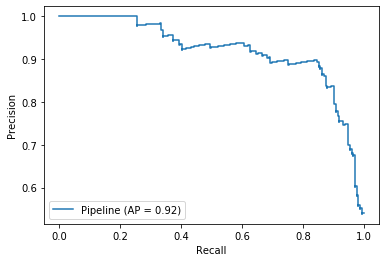

In [51]:
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])

попробуем найти precision > 0.95 

In [52]:
np.where(prec > 0.95)

(array([257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
        270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282,
        283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295,
        296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308,
        309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321,
        322, 323, 324, 325, 326], dtype=int64),)

In [58]:
thresholds[257]

0.6819051944678692

In [60]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[257])

0.9558823529411765

In [61]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1] > thresholds[257])

0.3693181818181818

Улучшаем параметры с помощью Greedearch. Поменяем коэффициент регуляризации. 

In [62]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", 
     GridSearchCV(
        LogisticRegression(random_state=0),
        param_grid={'C': [0.1, 1, 10.]},
        cv=3,
         verbose=4
        )
    )
])

In [64]:
grid_pipeline.fit(train_df["comment"], train_df["toxic"])

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.686, total=   0.1s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................... C=0.1, score=0.689, total=   0.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.686, total=   0.1s
[CV] C=1 .............................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s


[CV] ................................. C=1, score=0.837, total=   0.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.835, total=   0.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.835, total=   0.3s
[CV] C=10.0 ..........................................................


D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................. C=10.0, score=0.867, total=   0.5s
[CV] C=10.0 ..........................................................


D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[CV] .............................. C=10.0, score=0.861, total=   0.5s
[CV] C=10.0 ..........................................................


D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    2.5s finished


[CV] .............................. C=10.0, score=0.862, total=   0.5s


D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scali

In [65]:
model_pipeline_c_10 = Pipeline ([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x, remove_stop_words=True))),
    ("model", LogisticRegression(random_state=0, C=10.))
])

In [67]:
model_pipeline_c_10.fit(train_df["comment"], train_df["toxic"])

D:\Soft\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...\w\\w+\\b',
                                 tokenizer=<function <lambda> at 0x0000023871F4FDC8>,
                                 use_idf=True, vocabulary=None)),
                ('model',
                 LogisticRegression(C=10.0, class_weight=None, dual=False,
                                    fi

In [68]:
prec_c_10, rec_c_10, thresholds_c_10 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1])

In [70]:
np.where(prec_c_10 > 0.95)

(array([252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
        265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
        278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
        291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
        304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
        317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
        330, 331, 332, 333, 334, 335, 336, 337, 338], dtype=int64),)

In [72]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[252])

0.9529411764705882

In [73]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline_c_10.predict_proba(test_df["comment"])[:, 1] > thresholds_c_10[252])

0.4602272727272727